In [38]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle
import scipy
from scipy.interpolate import interp1d
import skimage
from skimage import io, exposure, filters

from numpy.fft import fftshift, fft2, ifft2, fft, ifft
from numpy import real
from numpy import conj

import tiff_file

%matplotlib notebook


Set the directory for where the data is below.

In [29]:
data_dir = "Y:\\ConorOSh\Data\\Light Sheet\\2021-08-12\\S13formation_FarLeft_25fps_2\\"
data_file = "S13formation_FarLeft_25fps_2_MMStack_Default.ome.tif"

#Enter the correct pixel size below: 
pixel_size = 0.194

In [31]:
images = skimage.io.imread(data_dir+data_file)
print("Number of frames in %s: %s" % (data_file, images.shape[0]))
print("Dimensions of an image is %i by %i pixels." % (images.shape[1], images.shape[2]))

Number of frames in S13formation_FarLeft_25fps_2_MMStack_Default.ome.tif: 500
Dimensions of an image is 516 by 2048 pixels.


<IPython.core.display.Javascript object>


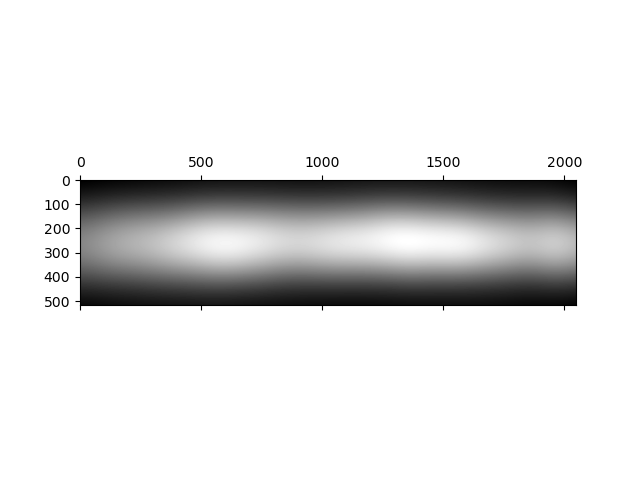

In [40]:
##Creating background

mean_image = images.mean(axis=0)
background = filters.gaussian(mean_image, sigma=60)

plt.figure()
plt.matshow(background, fignum=0, cmap='gray')

Below we define the function for 2D and 1D image autocorrelation

In [17]:
def autocorrelation_2D(image):
    data = image-image.mean() 
    data = data / data.std()
    
    temp = real(fftshift(ifft2(fft2(data)*conj(fft2(data)))))
    temp = temp / (data.shape[0]*data.shape[1])
    
    return temp

def autocorrelation_1D(image, ax):
    # This function computes a 1D correlation
    # of a 2D image. 
    # Input parameters:
    #    image -- a 2D numpy array
    #    ax -- the axis to perform the autocorrelation
    #
    # Note about which axes to use:
    #   for ax = 0: this will correlate things along the vertical direction when displayed using matshow
    #   for ax = 1: this will correlate along the horizontal direction when displayed using matshow
    
    means = image.mean(axis=ax)
    temp = np.tile(means, (image.shape[ax], 1))
    if ax==0:
        data = image - temp
    elif ax==1:
        data = image - temp.transpose()
    else:
        print("ax must be 0 or 1")
        return 0
    
    std_devs = data.std(axis=ax)
    #print("shape of std_devs: ", std_devs.shape) #for debugging purposes
    temp = np.tile(std_devs, (image.shape[ax],1))
    if ax==0:
        data = data / temp
    elif ax==1:
        data = data / temp.transpose()
        
    temp = fftshift(ifft(fft(data,axis=ax)*conj(fft(data,axis=ax)),axis=ax),axes=ax)
    temp = real(temp) / data.shape[ax]
       
    if ax==0:
        corr = temp.sum(axis=1)/temp.shape[1]
        return corr[int(temp.shape[0]/2):]
    elif ax==1:
        corr = temp.sum(axis=0)/temp.shape[0]
        return corr[int(temp.shape[1]/2):]
    
def find_where_corr_at_half(corr, val=0.5):
    # This function will actually only find where the correlation function goes to 0.5
    # (which, if properly normalized, means that it dropped 50%) if the "val" is set
    # to 0.5 which is the default. However, you can change that to another value like
    # 0.2 or 1/e or something else. 
    f = interp1d(np.arange(0,len(corr)), corr, kind='linear', fill_value="extrapolate") #create interpolation function
    new_x = np.linspace(0, len(corr), 10*len(corr))  #new x-axis that is 10 times more sampled
    eval_at_new_x = f(new_x) #evaluate the interpolated function over the new range of x-values
    min_index = np.argmin(abs(eval_at_new_x-val)) #find where that is closest to "val" 
    return new_x[min_index]

(500, 516, 2048)
(320, 320)


<IPython.core.display.Javascript object>


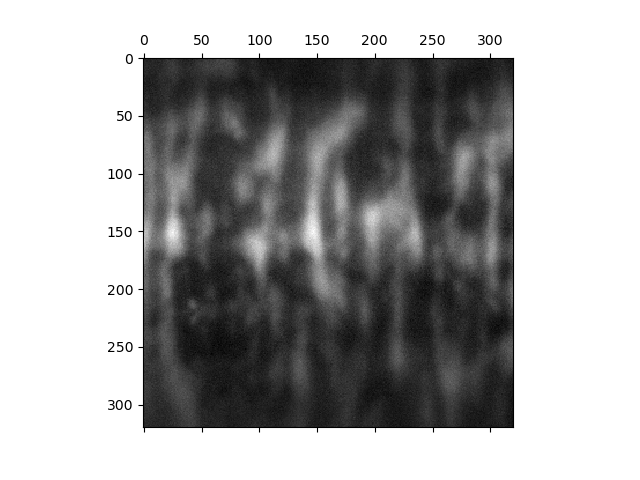

<IPython.core.display.Javascript object>


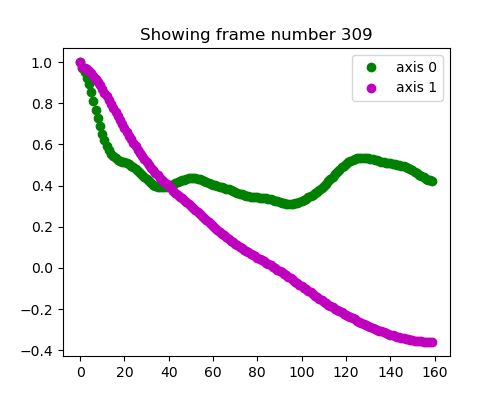

Where the correlation goes to 50% for axis 0:  143.5897435897436
Where the correlation goes to 50% for axis 1:  30.919324577861165


In [68]:
##################################
# Enter frame number to analyze  #
##################################
frame_to_show = 309

##################################
# Specify ROI to investigate     #
##################################
roi_x1 = 900
roi_x2 = 1220
roi_y1 = 100
roi_y2 = 420


im = images[frame_to_show, roi_y1:roi_y2, roi_x1:roi_x2]
bg = background[roi_y1:roi_y2, roi_x1:roi_x2]
print(images.shape)
print(im.shape)

#Creates figure and shows region to analyze
filtered_image_region = 1.0 * im - bg
plt.figure()
plt.matshow(filtered_image_region, fignum=0, cmap='gray') #shows image

corr2d = autocorrelation_2D(filtered_image_region - filtered_image_region.min())
plt.figure(figsize=(5,4))
acorr_0 = autocorrelation_1D(im,0)
acorr_1 = autocorrelation_1D(im,1)
#plt.plot(acorr_0,'bo',label='axis 0')
#plt.plot(acorr_1,'ro',label='axis 1')
acorr0_from2d = corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
acorr1_from2d = corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
plt.plot(acorr0_from2d, 'go', label='axis 0')
plt.plot(acorr1_from2d, 'mo', label='axis 1')
print("Where the correlation goes to 50% for axis 0: ", find_where_corr_at_half(acorr0_from2d))
print("Where the correlation goes to 50% for axis 1: ", find_where_corr_at_half(acorr1_from2d))
plt.title("Showing frame number %i" % frame_to_show)
plt.legend(loc=0)

#Create figure for 2D autocorrelation
#plt.figure()
#plt.matshow(corr2d, fignum=0, cmap='gray')

<IPython.core.display.Javascript object>


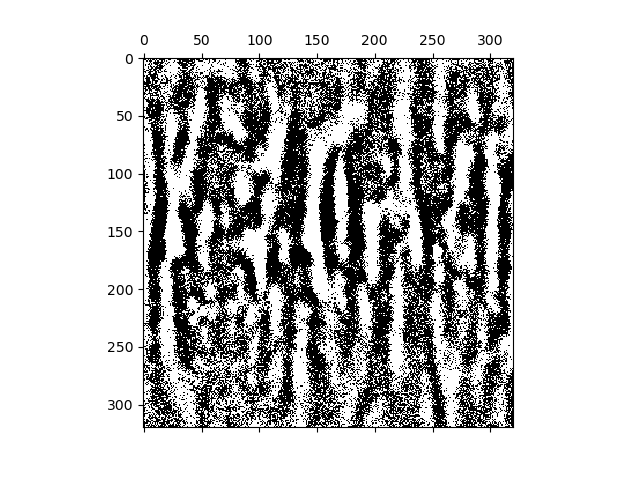

<IPython.core.display.Javascript object>


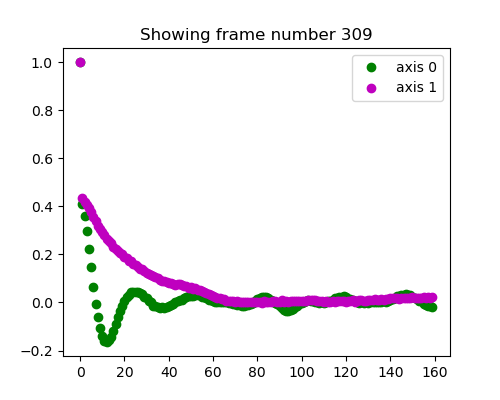

Where the correlation goes to 10% for axis 0:  5.603502188868043
Where the correlation goes to 10% for axis 1:  35.32207629768605


In [72]:
#Convert image to binary (black and white)
block_size = 35
local_threshold = filters.threshold_local(filtered_image_region, block_size, offset=10)
binary_image_region = filtered_image_region > local_threshold

#Creates figure and shows region to analyze
plt.figure()
plt.matshow(binary_image_region, fignum=0, cmap='gray') #shows image

corr2d = autocorrelation_2D(binary_image_region)
plt.figure(figsize=(5,4))
acorr_0 = autocorrelation_1D(binary_image_region,0)
acorr_1 = autocorrelation_1D(binary_image_region,1)
#plt.plot(acorr_0,'bo',label='axis 0')
#plt.plot(acorr_1,'ro',label='axis 1')
acorr0_from2d = corr2d[int(im.shape[0]/2),int(im.shape[1]/2):]
acorr1_from2d = corr2d[int(im.shape[0]/2):,int(im.shape[1]/2)]
plt.plot(acorr0_from2d, 'go', label='axis 0')
plt.plot(acorr1_from2d, 'mo', label='axis 1')
print("Where the correlation goes to 10% for axis 0: ", find_where_corr_at_half(acorr0_from2d, val=0.1))
print("Where the correlation goes to 10% for axis 1: ", find_where_corr_at_half(acorr1_from2d, val=0.1))
plt.title("Showing frame number %i" % frame_to_show)
plt.legend(loc=0)